In [3]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.applications import VGG19
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Skimage      : 0.19.3
Scikit-learn : 1.0.2
Keras        : 2.6.0
Tensorflow   : 2.6.4


In [4]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

In [5]:
from tqdm import tqdm 
from zipfile import ZipFile

In [6]:
with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test") 

In [7]:
train_path = '/kaggle/working/stage1_train'  
test_path = '/kaggle/working/stage1_test'

In [8]:
img_height, img_width = (256,256) 

In [9]:
%%time
# Get training data
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data
X_train = get_X_data(train_path, output_shape=(img_height,img_width))
print(X_train.shape, X_train.dtype)

(670, 256, 256, 3) uint8
CPU times: user 21.1 s, sys: 1.08 s, total: 22.2 s
Wall time: 22.4 s


In [10]:
from skimage.color import rgb2gray

X_train_ = rgb2gray(X_train)
print(X_train_.shape)
X_train = np.expand_dims(X_train_, axis=-1)
print(X_train.shape)

(670, 256, 256)
(670, 256, 256, 1)


In [11]:
%%time
# Get training data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data
Y_train = get_Y_data(train_path, output_shape=(img_height,img_width))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 46 s, sys: 4.42 s, total: 50.5 s
Wall time: 50.7 s


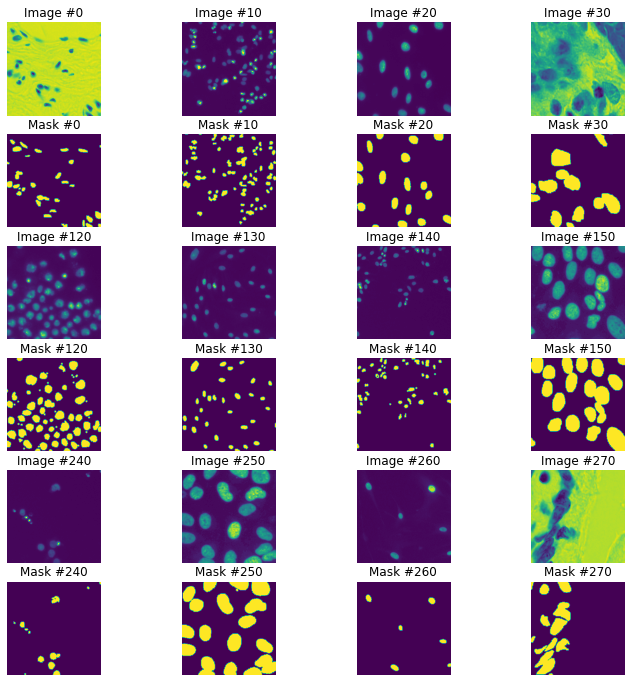

In [12]:
# Illustrate the train images and masks
plt.figure(figsize=(12,12))
x, y = 4,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    """ RESUNET Architecture """

    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

In [14]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [20]:
# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [mean_iou]
input_shape=(253, 256, 1)
# Compile our model
model = build_resunet((256,256,1))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])


Model: "RESUNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 64) 256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 256, 256, 64) 0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [21]:
from keras.preprocessing.image import ImageDataGenerator
# Runtime data augmentation
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.1, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator, X_train, X_test, Y_train, Y_test

In [22]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

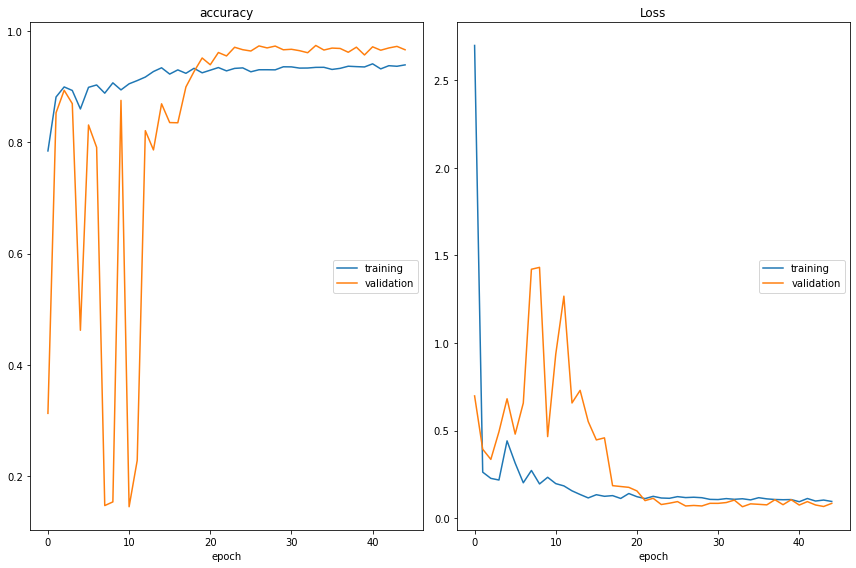

accuracy
	training         	 (min:    0.784, max:    0.941, cur:    0.939)
	validation       	 (min:    0.145, max:    0.974, cur:    0.966)
Loss
	training         	 (min:    0.093, max:    2.699, cur:    0.095)
	validation       	 (min:    0.065, max:    1.432, cur:    0.084)


In [24]:
from livelossplot.inputs.tf_keras import PlotLossesCallback
# Finally train the model!!
batch_size = 8

train_generator, test_generator, X_train, X_val, Y_train, Y_val = get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.1, batch_size=batch_size)
# increase epoch on your own machine
model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=45, callbacks=[PlotLossesCallback(),earlystopping, reduce_lr])

In [25]:
topDir = '/kaggle'
model.save_weights(filepath=topDir+"/working/model-weights.hdf5")


In [26]:
# Predict on val
preds_val = model.predict(X_val, verbose=1)
# Threshold predictions
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5)

2/2 [==============================] - 24s 11s/step


In [27]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [28]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
for i in range(len(Y_val)):
    iou.append(cal_iou(np.squeeze(Y_val[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: 0.78


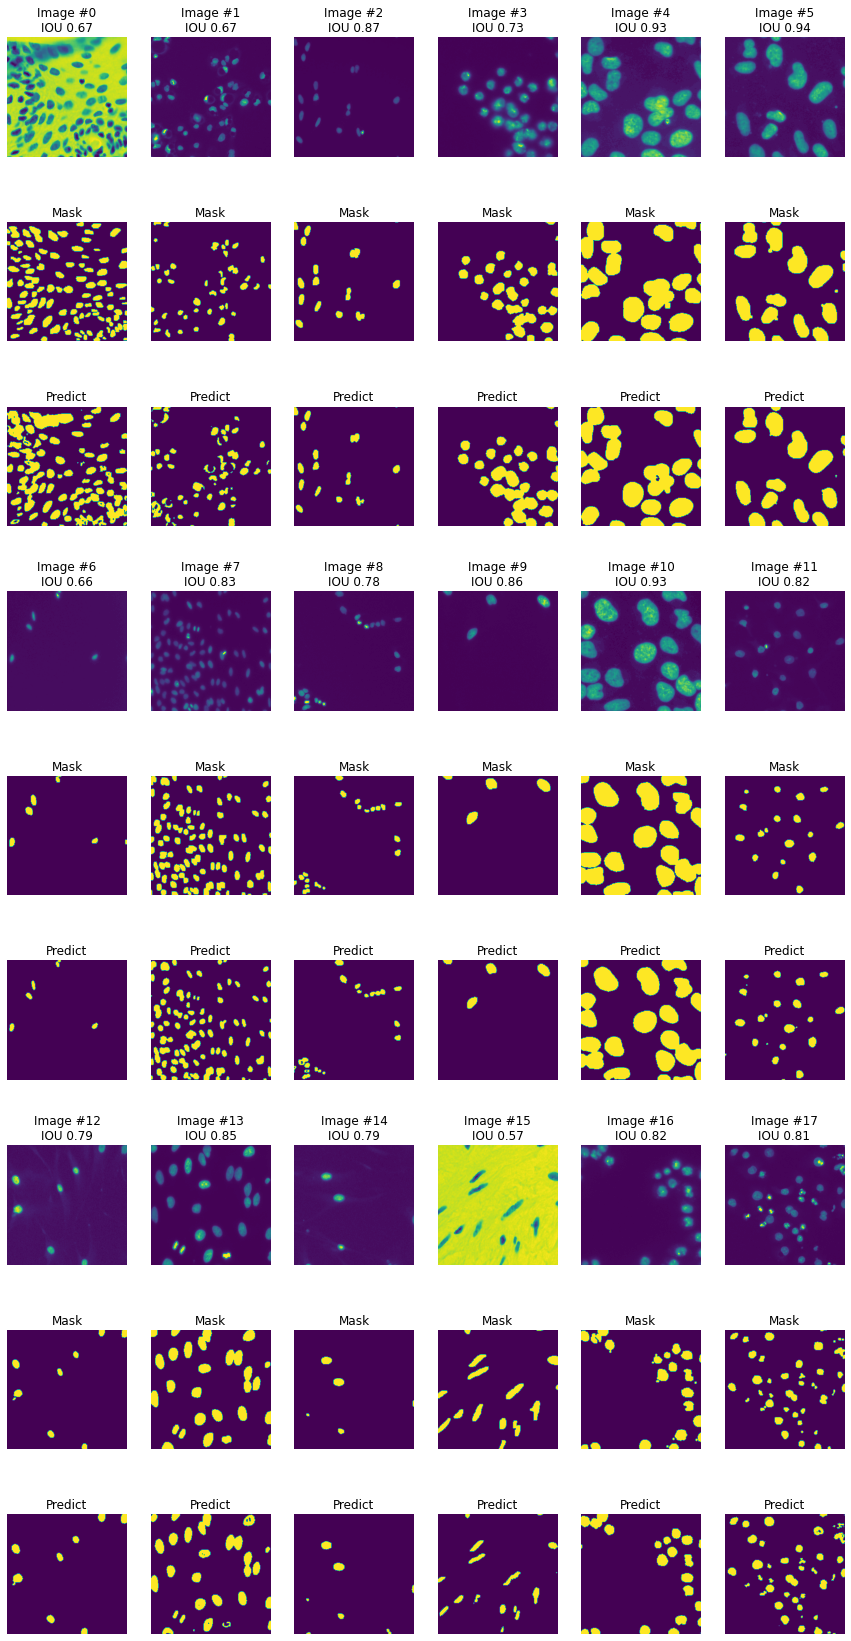

In [46]:
#plt.figure(figsize=(12,8))
plt.figure(figsize=(15,30))
x, y = 6,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()